# Load data

In [1]:
import sys
sys.path.append(r'D:\Programming\3rd_party\keras')

In [2]:
import sys
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
import pandas as pd

import keras

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from skimage.transform import resize
import cv2
from tqdm import tqdm_notebook

c:\miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import load_data
load_data = reload(load_data)

In [4]:
DEV_MODE_RANGE = 0 # off

In [5]:
train_df = load_data.LoadData(train_data = True, DEV_MODE_RANGE = DEV_MODE_RANGE)

(3920, 9) (18000, 1) (22000, 1)


HBox(children=(IntProgress(value=0, max=3920), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3920), HTML(value='')))

In [6]:
test_df = load_data.LoadData(train_data = False, DEV_MODE_RANGE = DEV_MODE_RANGE)

(3920, 9) (18000, 1) (22000, 1)


HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))

In [7]:
test_fold_no = 1

In [8]:
_, _, validate_images, validate_masks = load_data.SplitTrainData(train_df, test_fold_no)
validate_images.shape, validate_masks.shape

((784,), (784,))

In [9]:
test_images = test_df.images
test_images.shape

(18000,)

# IOU metric

In [10]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    assert (img_true.shape[-1]==1) and (len(img_true.shape)==3) or (img_true.shape[-1]!=1) and (len(img_true.shape)==2)
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(img_true, img_pred):
    img_pred = img_pred > 0.5 # added by sgx 20180728
    if img_true.sum() == img_pred.sum() == 0:
        scores = 1
    else:
        scores = (thresholds <= iou(img_true, img_pred)).mean()
    return scores

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = len(y_true_in)
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("metric = ",metric)
    return np.mean(metric)

# adapter for Keras
def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value


# Data generator

In [11]:
mean_val = 0.481577
mean_std = 0.11108
mean_val, mean_std 

(0.481577, 0.11108)

In [12]:
sys.path.insert(1, '../3rd_party/albumentations')
sys.path.insert(1, '../3rd_party/imgaug')
import albumentations

In [13]:
augmented_image_size = 303
nn_image_size = 224

In [14]:
def basic_aug(p=1.):
    return albumentations.Compose([
        albumentations.Resize(augmented_image_size, augmented_image_size),
        albumentations.HorizontalFlip(),
        albumentations.RandomCrop(nn_image_size, nn_image_size),
        albumentations.Normalize(mean = mean_val, std = mean_std, max_pixel_value = 1.0),
    ], p=p)

In [15]:
import threading
class AlbuDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images, masks, batch_size=32, nn_image_size = 96, shuffle=True, aug_func = basic_aug):
        'Initialization'
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.nn_image_size = nn_image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()
        self.augmentation = aug_func()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.nn_image_size,self.nn_image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, self.nn_image_size,self.nn_image_size, 1), dtype=np.float32)

        # Generate data
        for i, index in enumerate(indexes):
            image = self.images[index]
            mask = None if self.masks is None else self.masks[index]
            aug_res = self.augmentation(image = image, mask = mask)
            image = aug_res['image']
            X[i, ...] = image
            mask = aug_res['mask']
            y[i, ...] = mask.reshape(mask.shape[0], mask.shape[1], 1)

        return X, y

# model

In [16]:
sys.path.append('../3rd_party/segmentation_models')
import segmentation_models
segmentation_models = reload(segmentation_models)
from segmentation_models.utils import set_trainable


In [17]:
model_name = 'FNN'
backbone_name='resnet34'
test_batch_size = 50

In [18]:
model_out_file = 'models_2_180922/{model_name}_{backbone_name}_{test_fold_no}.model'.format(model_name=model_name, backbone_name=backbone_name, test_fold_no=test_fold_no)
model_out_file

'models_2_180922/FNN_resnet34_1.model'

In [19]:
model = load_model(model_out_file, custom_objects={'my_iou_metric': my_iou_metric}) #, 'lavazs_loss': lavazs_loss

# Train evaluation

In [20]:
val_gen = AlbuDataGenerator(validate_images, validate_masks, batch_size=test_batch_size, nn_image_size = nn_image_size, shuffle=False)

In [21]:
sys.path.append('../3rd_party/keras-tqdm')
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

In [28]:
eval_res = []
for i in range (10):
    r = model.evaluate_generator(val_gen, max_queue_size=10, workers=5, use_multiprocessing=False)
    eval_res.append(r)
    print (i,r)
np.mean(np.array(eval_res)[:, 2]), np.std(np.array(eval_res)[:, 2]) 

0 [0.11173935164697468, 0.9571719542145729, 0.8305]
1 [0.10170613345690072, 0.9615404717624187, 0.8240000000000001]
2 [0.1192251245956868, 0.9543693661689758, 0.815625]
3 [0.11709983786568046, 0.9559994339942932, 0.806875]
4 [0.1189550266135484, 0.9540063664317131, 0.8207499999999999]
5 [0.12670886935666203, 0.9541661106050014, 0.8101249999999999]
6 [0.11540585360489786, 0.9502251334488392, 0.8075]
7 [0.1175463693216443, 0.9557234570384026, 0.8217500000000001]
8 [0.12378048384562135, 0.9542752802371979, 0.8237500000000001]
9 [0.108380924211815, 0.9576830267906189, 0.80475]


0.6293777858403822

In [31]:
np.mean(np.array(eval_res)[:, 2]), np.std(np.array(eval_res)[:, 2]) 

(0.8165625000000001, 0.00838753725774142)

# Single model output

In [32]:
def PredictByTiles(imgs, n):
    '''
    imgs of size (303x303x3)
    n  - tiles are n*n
    -> mask (303x303, float)
    '''
    np_imgs = np.array(imgs)
    print (np_imgs.shape)
    mask_enlarged = np.zeros(np.array(imgs).shape[:-1], dtype = np.float32)
    mask_counters = np.zeros(np.array(imgs).shape[:-1], dtype = np.int)
    if n>1:
        hstep = (augmented_image_size - nn_image_size)//(n-1)
        vstep = (augmented_image_size - nn_image_size)//(n-1)
    for i in range(n):
        top = i*vstep if i != n-1 else augmented_image_size-nn_image_size
        for j in range(n):
            left = j*hstep if j != n-1 else augmented_image_size-nn_image_size
            sub_imgs = np_imgs[:, top:top+nn_image_size, left:left+nn_image_size, :]
            print (sub_imgs.shape, i, j)
            predicts = model.predict(sub_imgs).reshape(-1, sub_imgs.shape[1], sub_imgs.shape[2])
            sub_mask = mask_enlarged[:, top:top+nn_image_size, left:left+nn_image_size]
            sub_mask_counters = mask_counters[:, top:top+nn_image_size, left:left+nn_image_size]
            assert sub_mask.shape == predicts.shape
            assert sub_mask_counters.shape == predicts.shape
            sub_mask += predicts
            sub_mask_counters += 1
    if n>1:
        mask_enlarged = np.divide(mask_enlarged, mask_counters)
    return mask_enlarged
    

In [33]:
def PredictByTilesAndFlip(df_enlarge, n):
    mask_float =      PredictByTiles(df_enlarge, n)
    
    df_enlarge_flip = [np.fliplr(x) for x in df_enlarge]
    mask_float_flip = PredictByTiles(df_enlarge_flip, n)
    mask_float = 0.5*(mask_float + np.array([np.fliplr(a) for a in mask_float_flip]))
    is_empty_imgs = [np.sum(x) == 0 for x in df_enlarge]
    mask_float[is_empty_imgs,...] = 0
    
    return mask_float

In [34]:
def Predict(df, n = 2, threshold=0.5):
    df_enlarge = [cv2.resize((x - mean_val)/mean_std, (augmented_image_size, augmented_image_size)) for x in df]
    mask_float = PredictByTilesAndFlip(df_enlarge, n)
    mask_ori = [cv2.resize(np.array(filter_image(img),dtype = np.float32), df[0].shape[:2]) for img in mask_float > threshold]
    return mask_ori

In [35]:
df = validate_images
# enlarge and normalize
df_enlarge = [cv2.resize((x - mean_val)/mean_std, (augmented_image_size, augmented_image_size)) for x in df]
n = 2

In [36]:
mask_float = PredictByTilesAndFlip(df_enlarge, n)


(784, 303, 303, 3)
(784, 224, 224, 3) 0 0
(784, 224, 224, 3) 0 1
(784, 224, 224, 3) 1 0
(784, 224, 224, 3) 1 1
(784, 303, 303, 3)
(784, 224, 224, 3) 0 0
(784, 224, 224, 3) 0 1
(784, 224, 224, 3) 1 0
(784, 224, 224, 3) 1 1


In [37]:
del df_enlarge

In [38]:
import gc
gc.collect()

5

In [39]:
if n==1:
    validate_masks = [cv2.resize(cv2.resize(x,(303,303))[:224,:224], (101,101)) for x in validate_masks]

In [40]:
if n==1:
    mask_float = [cv2.resize(cv2.resize(x,(303,303))[:224,:224], (101,101)) for x in mask_float]

In [41]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

In [42]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(validate_masks, [cv2.resize(np.array(filter_image(img),dtype = np.float32), validate_masks[0].shape) for img in mask_float > threshold]) for threshold in tqdm_notebook(thresholds)])


HBox(children=(IntProgress(value=0, max=31), HTML(value='')))

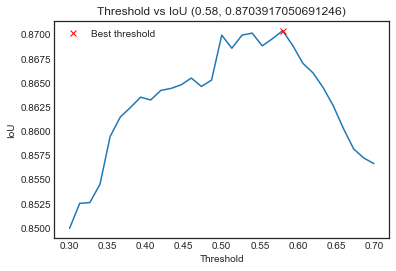

In [43]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [44]:
threshold_best

0.58

In [45]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [46]:
pos = 0
step = 2000

while pos < len(test_images):
    if pos == 0:
        preds_test = Predict(test_images[pos:pos+step], n = n, threshold = threshold_best)
    else:
        preds_test += Predict(test_images[pos:pos+step], n = n, threshold = threshold_best)
    pos = pos+step
    print(len(preds_test))

(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
2000
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
4000
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
6000
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 224, 224, 3) 0 1
(2000, 224, 224, 3) 1 0
(2000, 224, 224, 3) 1 1
8000
(2000, 303, 303, 3)
(2000, 224, 224, 3) 0 0
(2000, 2

In [47]:
len(preds_test)

18000

In [48]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))


Usedtime = 3.8733534812927246 s


In [49]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(model_out_file+'.submission.csv.gz', compression = 'gzip')

In [50]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,809 1 910 3 1011 3 1112 3 1117 8 1213 16 1314 ...
64dba827d6,
0a3a8a5f37,
329563756f,1 4645 4647 100 4748 100 4849 98 4950 98 5051 ...
f6cba2e890,


In [ ]:
preds_test2 = filter_image(preds_test > threshold_best)
test_df['pred']= None
for i, idx in enumerate(tqdm_notebook(test_df.index.values)
    test_df.loc[idx, 'pred'] = preds_test2[i]


In [ ]:
preds_test.shape, preds_test2.shape